<a href="https://colab.research.google.com/github/Deepak8597/Uber-Data-Analysis-to-predict-the-price/blob/master/Uber_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ***Uber Data Analysis to predict the price***

In [1]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LinearRegression
import seaborn as sns
import gc
import os
import sys
%matplotlib inline

In [2]:
# Memory saving function

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


In [4]:
cab=pd.read_csv('cab_rides.csv')
cab=reduce_mem_usage(cab)
weather=pd.read_csv('weather.csv')
weather=reduce_mem_usage(weather)

Memory usage of dataframe is 0.63 MB
Memory usage after optimization is: 0.54 MB
Decreased by 13.6%
Memory usage of dataframe is 0.38 MB
Memory usage after optimization is: 0.10 MB
Decreased by 73.3%


In [ ]:
cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.439941,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.439941,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.439941,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.439941,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.439941,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [ ]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.40625,Back Bay,1.0,1012.0,0.122803,1545003901,0.770020,11.250000
1,42.43750,Beacon Hill,1.0,1012.0,0.184570,1545003901,0.759766,11.320312
2,42.50000,Boston University,1.0,1012.0,0.108887,1545003901,0.759766,11.070312
3,42.12500,Fenway,1.0,1012.0,0.096924,1545003901,0.770020,11.093750
4,43.12500,Financial District,1.0,1012.0,0.178589,1545003901,0.750000,11.492188


In [ ]:
cab.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [ ]:
weather.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind'],
      dtype='object')

In [5]:
import datetime
cab['datetime']=pd.to_datetime(cab['time_stamp'])
cab
weather['datetime']=pd.to_datetime(weather['time_stamp'])
weather

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,datetime
0,42.40625,Back Bay,1.000000,1012.0,0.122803,1545003901,0.770020,11.250000,1970-01-01 00:00:01.545003901
1,42.43750,Beacon Hill,1.000000,1012.0,0.184570,1545003901,0.759766,11.320312,1970-01-01 00:00:01.545003901
2,42.50000,Boston University,1.000000,1012.0,0.108887,1545003901,0.759766,11.070312,1970-01-01 00:00:01.545003901
3,42.12500,Fenway,1.000000,1012.0,0.096924,1545003901,0.770020,11.093750,1970-01-01 00:00:01.545003901
4,43.12500,Financial District,1.000000,1012.0,0.178589,1545003901,0.750000,11.492188,1970-01-01 00:00:01.545003901
...,...,...,...,...,...,...,...,...,...
6271,44.71875,North Station,0.890137,1000.5,NaN,1543819974,0.959961,1.519531,1970-01-01 00:00:01.543819974
6272,44.84375,Northeastern University,0.879883,1000.5,NaN,1543819974,0.959961,1.540039,1970-01-01 00:00:01.543819974
6273,44.81250,South Station,0.890137,1000.5,NaN,1543819974,0.959961,1.540039,1970-01-01 00:00:01.543819974
6274,44.78125,Theatre District,0.890137,1000.5,NaN,1543819974,0.959961,1.540039,1970-01-01 00:00:01.543819974


In [ ]:
cab.shape

(16405, 11)

In [ ]:
weather.shape

(6276, 9)

In [ ]:
cab.describe()

,distance,time_stamp,price,surge_multiplier
count,16405.000000,1.640500e+04,1.511100e+04,16405.000000
mean,2.150391,1.544031e+12,inf,1.014648
std,1.120117,6.876294e+08,9.203125e+00,0.093567
min,0.020004,1.543204e+12,2.500000e+00,1.000000
25%,1.259766,1.543439e+12,9.000000e+00,1.000000
50%,2.080078,1.543721e+12,1.350000e+01,1.000000
75%,2.859375,1.544813e+12,2.250000e+01,1.000000
max,7.460938,1.545161e+12,8.000000e+01,2.500000


In [ ]:
weather.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000,894.000000,6.276000e+03,6276.000000,6276.000000
mean,inf,0.677734,inf,0.057648,1.543857e+09,0.764160,6.800781
std,6.019531,0.314453,12.875,0.100769,6.659340e+05,0.127319,3.632812
min,19.625000,0.000000,988.000,0.000200,1.543204e+09,0.449951,0.290039
25%,36.085938,0.439941,997.875,0.004902,1.543387e+09,0.669922,3.517090
50%,40.125000,0.779785,1007.500,0.014847,1.543514e+09,0.759766,6.570312
75%,42.843750,0.970215,1018.500,0.060913,1.544691e+09,0.890137,9.921875
max,55.406250,1.000000,1035.000,0.780762,1.545159e+09,0.990234,18.187500


In [6]:
a=pd.concat([cab,weather])

In [ ]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,humidity,wind
0,0.439941,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.439941,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.439941,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.439941,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.439941,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
import datetime
a['day']=a.datetime.dt.day
a['hour']=a.datetime.dt.hour

In [ ]:
a.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind,day,hour
6271,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:01.543819974,44.71875,North Station,0.890137,1000.5,NaN,0.959961,1.519531,1,1
6272,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:01.543819974,44.84375,Northeastern University,0.879883,1000.5,NaN,0.959961,1.540039,1,1
6273,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:01.543819974,44.81250,South Station,0.890137,1000.5,NaN,0.959961,1.540039,1,1
6274,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:01.543819974,44.78125,Theatre District,0.890137,1000.5,NaN,0.959961,1.540039,1,1
6275,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:01.543819974,44.68750,West End,0.890137,1000.5,NaN,0.959961,1.519531,1,1


In [9]:
a.fillna(0,inplace=True)

In [10]:
a

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind,day,hour
0,0.439941,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952607890,0.00000,0,0.000000,0.0,0.0,0.000000,0.000000,1,0
1,0.439941,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284023677,0.00000,0,0.000000,0.0,0.0,0.000000,0.000000,1,0
2,0.439941,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366822198,0.00000,0,0.000000,0.0,0.0,0.000000,0.000000,1,0
3,0.439941,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553582749,0.00000,0,0.000000,0.0,0.0,0.000000,0.000000,1,0
4,0.439941,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463360223,0.00000,0,0.000000,0.0,0.0,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6271,0.000000,0,1543819974,0,0,0.0,0.0,0,0,0,1970-01-01 00:00:01.543819974,44.71875,North Station,0.890137,1000.5,0.0,0.959961,1.519531,1,0
6272,0.000000,0,1543819974,0,0,0.0,0.0,0,0,0,1970-01-01 00:00:01.543819974,44.84375,Northeastern University,0.879883,1000.5,0.0,0.959961,1.540039,1,0
6273,0.000000,0,1543819974,0,0,0.0,0.0,0,0,0,1970-01-01 00:00:01.543819974,44.81250,South Station,0.890137,1000.5,0.0,0.959961,1.540039,1,0
6274,0.000000,0,1543819974,0,0,0.0,0.0,0,0,0,1970-01-01 00:00:01.543819974,44.78125,Theatre District,0.890137,1000.5,0.0,0.959961,1.540039,1,0


In [11]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'day',
       'hour'],
      dtype='object')

In [ ]:
a.groupby('cab_type').count()

,distance,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,humidity,wind
cab_type,,,,,,,,,,,,,,,,
0,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276
Lyft,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099
Uber,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527


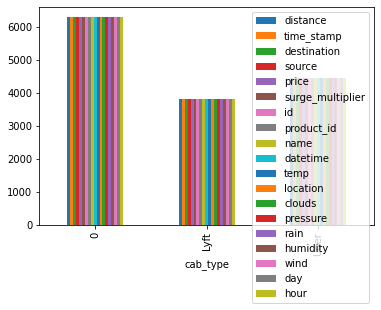

In [12]:
a.groupby('cab_type').count().plot.bar()

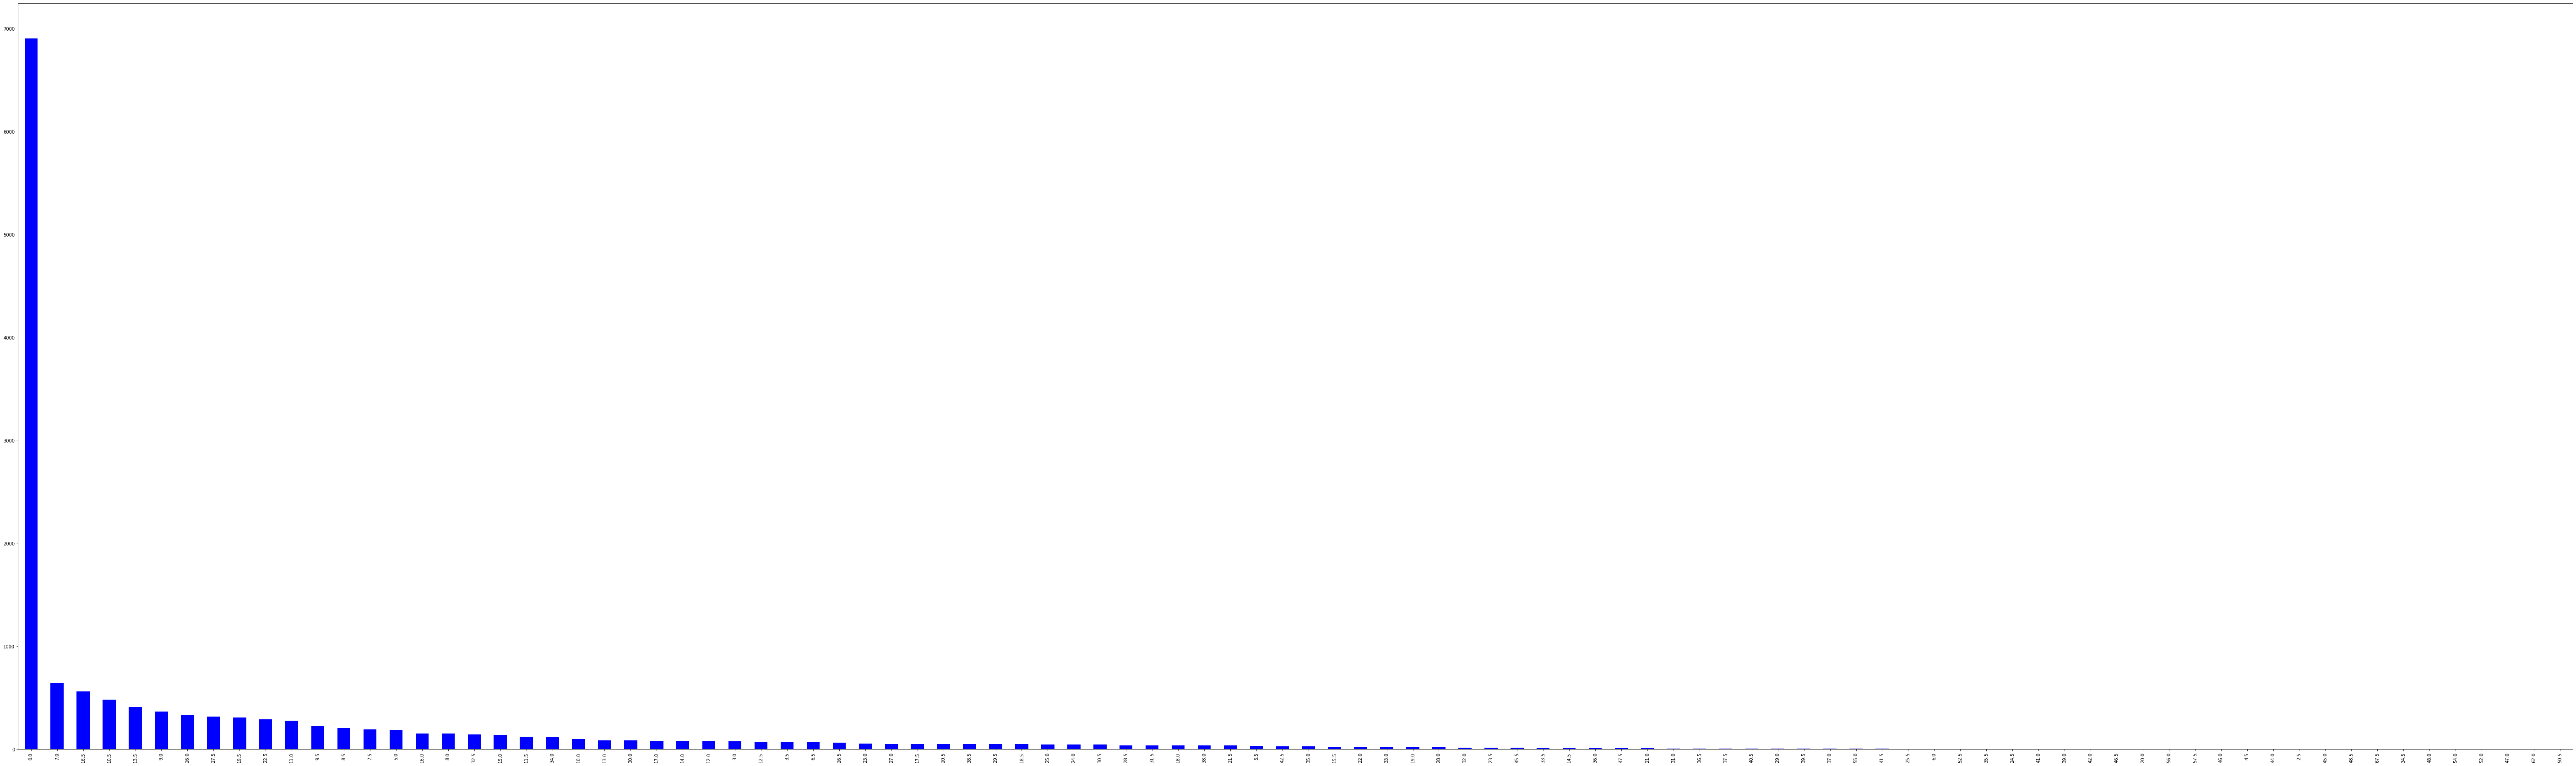

In [13]:
a['price'].value_counts().plot(kind='bar',figsize=(100,30),color='blue')

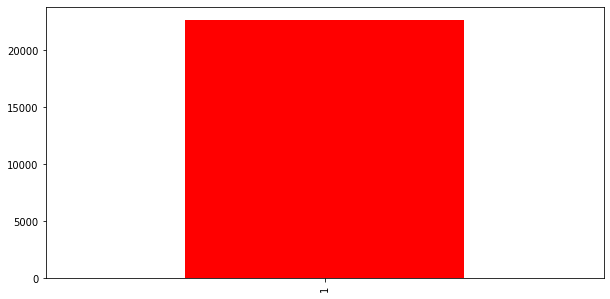

In [ ]:
a['hour'].value_counts().plot(kind='bar',figsize=(10,5),color='red')

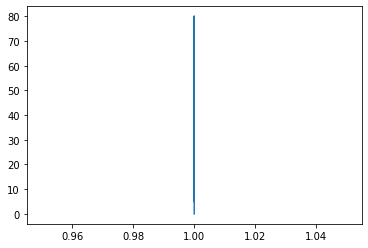

In [ ]:
x=a['hour']
y=a['price']
plt.plot(x,y)
plt.show()

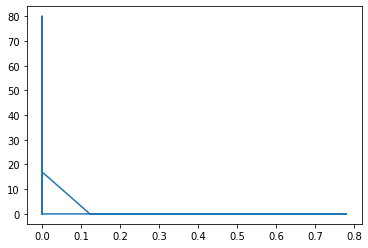

In [ ]:
x=a['rain']
y=a['price']
plt.plot(x,y)
plt.show()

In [14]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'day',
       'hour'],
      dtype='object')

In [15]:
x1=a[['distance','temp','pressure','humidity','wind','rain','day','hour','surge_multiplier','clouds']]
y1=a['price']

In [17]:
#Using skicit-learn to split data into traiining and testing
from sklearn.model_selection import  train_test_split
#Split the data into training and testing setss
x_train,y_train,x_test,y_test = train_test_split(x1,y1,test_size = 0.25,random_state = 42)


In [19]:
linear=LinearRegression()
linear.fit(x_train,x_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
predictions=linear.predict(y_train)
predictions

array([ 0.11667838, 10.93572753, -0.02814939, ...,  0.0865283 ,
       -0.04398829, 17.21068149])

In [28]:
df=pd.DataFrame({'actual':y_test,'Predicted':predictions})
df

,actual,Predicted
5472,0.0,0.116678
2375,5.0,10.935728
5430,0.0,-0.028149
4223,0.0,-0.087250
169,20.5,20.424186
...,...,...
6632,16.5,13.338672
4187,0.0,-0.068363
3885,0.0,0.086528
4387,0.0,-0.043988


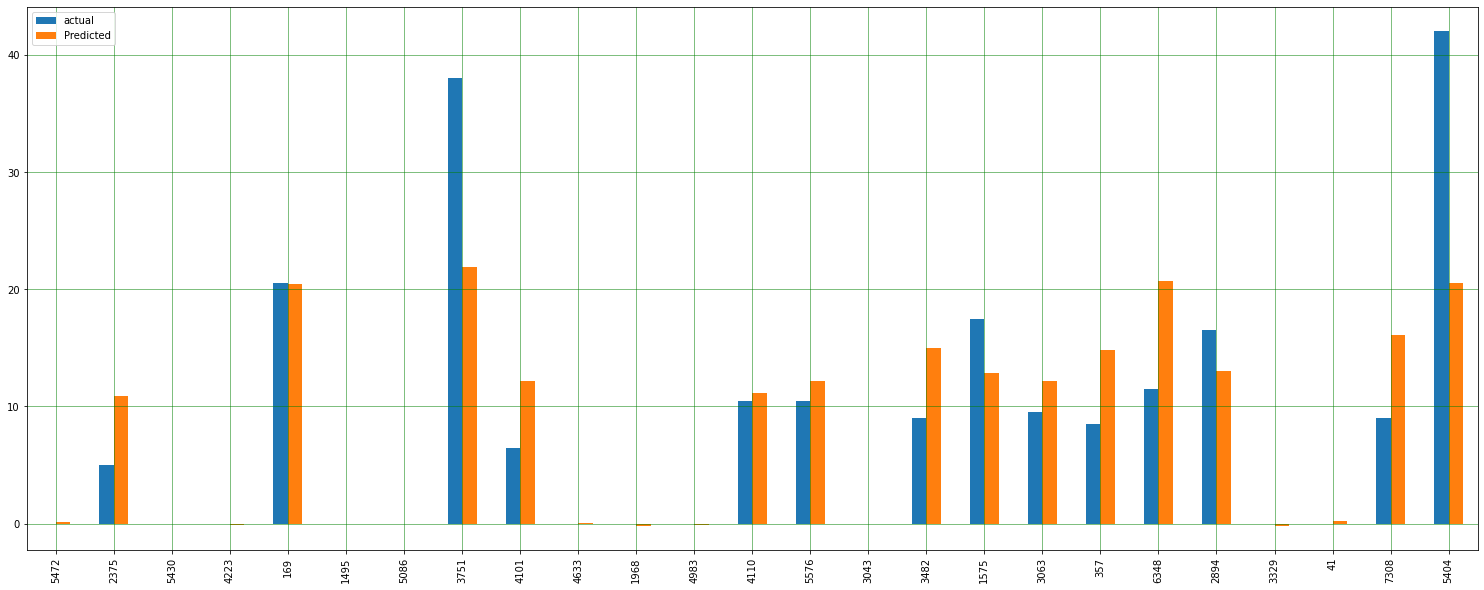

In [30]:
df1=df.head(25)
df1.plot(kind='bar',figsize=(26,10))
plt.grid(which='major',linestyle='-',linewidth='0.5', color='green')
plt.grid(which='minor',linestyle=':',linewidth='0.5', color='black')
plt.show()
